In [14]:
import os
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from data_handler import read_dfs, make_data_mlp
from helper import plot_logs, shapley, saliency_MLP
from networks import make_trainer, FeatureMLP

# Define GPU number
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
num_workers = 0 # Set to your device
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [15]:
# Create Dataloaders
train_dfs, val_dfs, test_dfs = read_dfs()
train_dataset, val_dataset, test_dataset, train_loader, valid_loader, test_loader = make_data_mlp(train_dfs, val_dfs, test_dfs, BATCH_SIZE=BATCH_SIZE, num_workers=num_workers)

In [21]:
# Initialize the model and trainer
model_mlp = FeatureMLP(train_loader,valid_loader,test_loader)
trainer = make_trainer(subdir="v1",max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
# Model Creation/Saving/Loading. Comment relevant lines to fit, save, load from model file or checkpoint 
# trainer.fit(model_mlp)
# torch.save(model_mlp,"./models/v1/model_1.pt")
# model_mlp = torch.load("./models/v1/model_1.pt")
model_mlp = FeatureMLP.load_from_checkpoint("./checkpoints_section/v1/epoch=97-step=15092.ckpt", trainloader = train_loader, valloader = valid_loader, testloader = test_loader)

In [23]:
trainer.test(model_mlp,test_loader);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         test_acc          │    0.6755287051200867     │
│         test_loss         │    0.9999099373817444     │
└───────────────────────────┴───────────────────────────┘

100


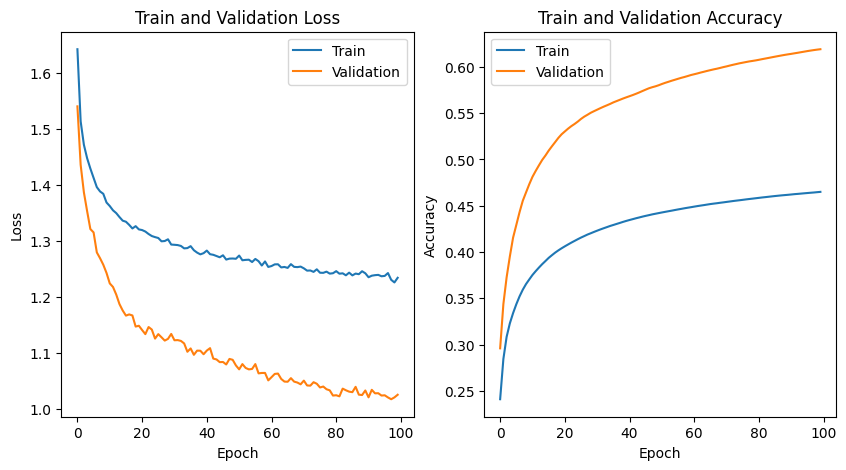

In [26]:
METRICS_PATH = "./logs_task/v1/lightning_logs/version_25"
plot_logs(METRICS_PATH, show=True)

In [8]:
# Get saliency stats and save results
grad_stats_list = saliency_MLP(test_dataset,model_mlp)
np.save("./results/v1/stats.npy",np.array(grad_stats_list))

WARNING - validity/relevance not ensured due to inconsistent input types


In [11]:
np.random.seed(321)
results_indices = np.random.randint(0,len(test_dfs),size=100)
print(results_indices)
saliency_MLP(test_dataset,model_mlp, index_list=results_indices,save_plot=True);

[ 6682  4220 11039  5929 11976  9617  8360  3482   984  8549 12616  9211
 11859 11477  5249 13083 12826  9332  4285  4621  8491  6206 10655  1418
  7031 13346  1458  9228  5790  3553  3837  8427 11122  6045  4609  9633
 11776  2820  5195  6139 12212  9978 12655  4075  6160  3647 10963 13479
 12574 10372  1421 13349 12999  2816  2443 11274 13051  1368   135  2368
  6626  7718  9521 10987  1135   624 13303  5250  1496  9411  1024  4627
 11593  2876  1790   568  5957  3167  9142  7664 10738  9975 11013  8738
  3580  4954 10899  5081  8457  8004  8223  5514 10778  6190 11009  6647
 11933  8890  7156  3803]
WARNING - validity/relevance not ensured due to inconsistent input types


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(13824, 20)
(200, 20)


  0%|          | 0/200 [00:00<?, ?it/s]

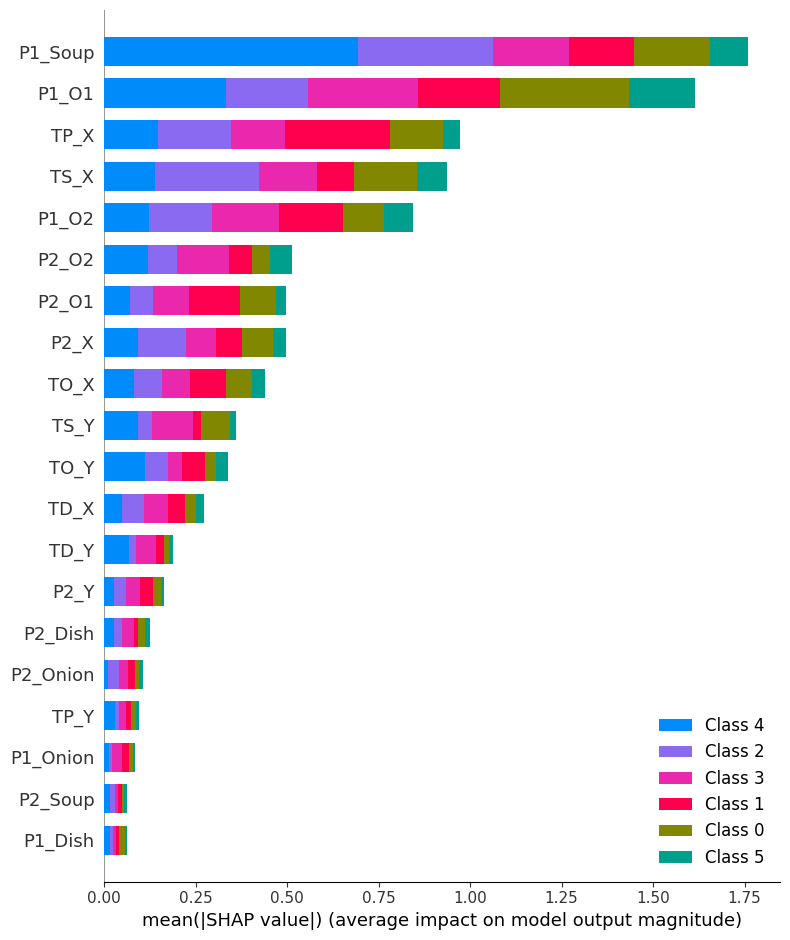

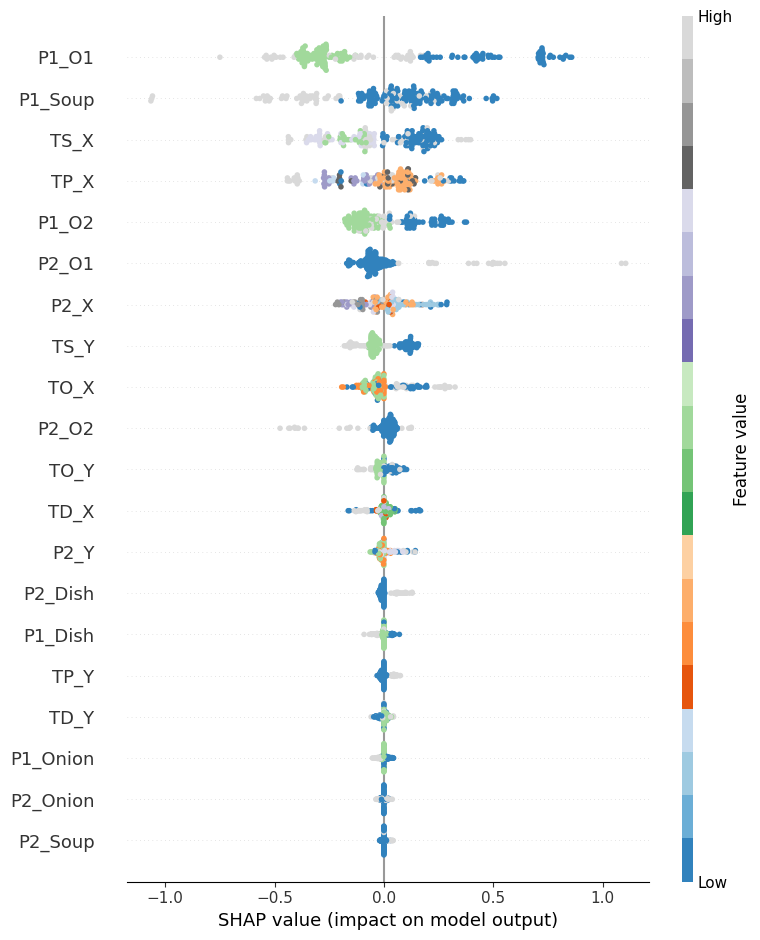

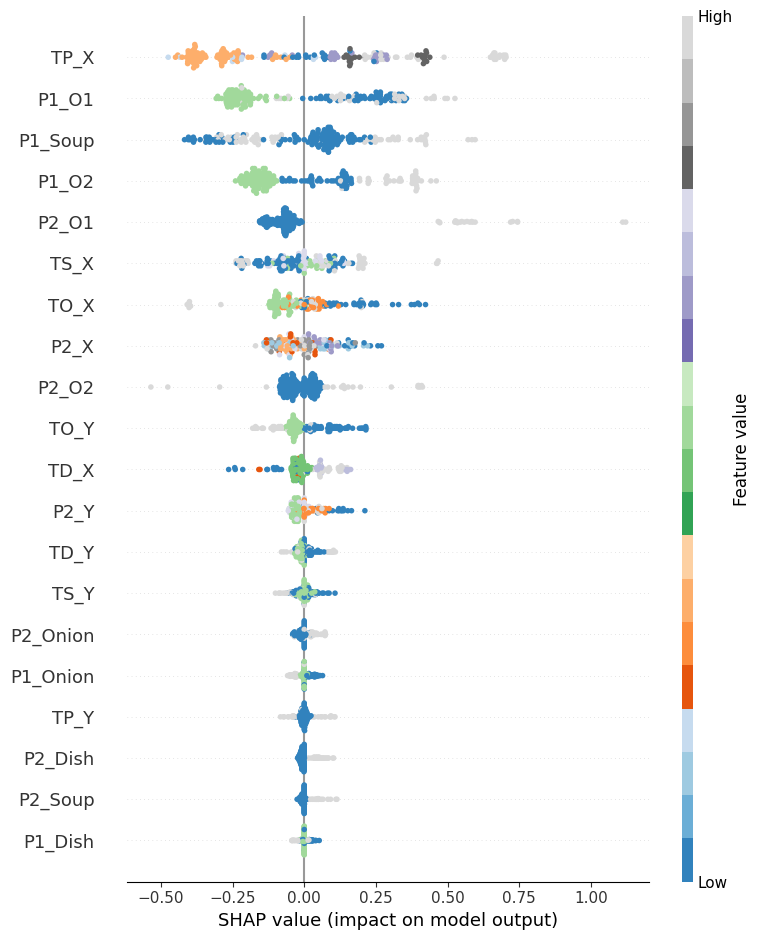

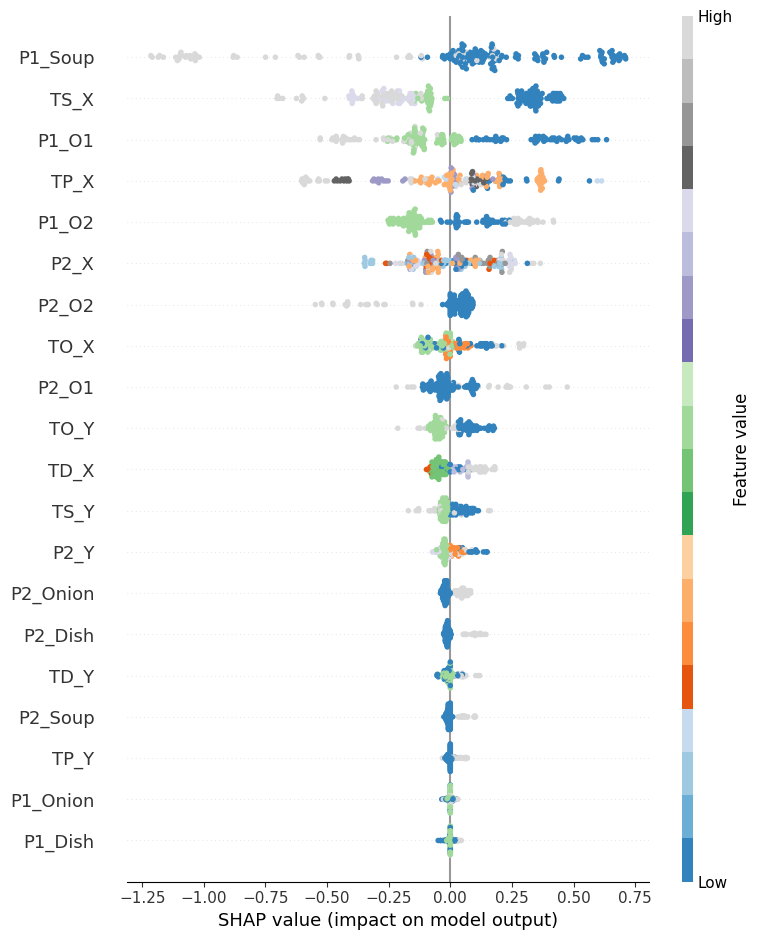

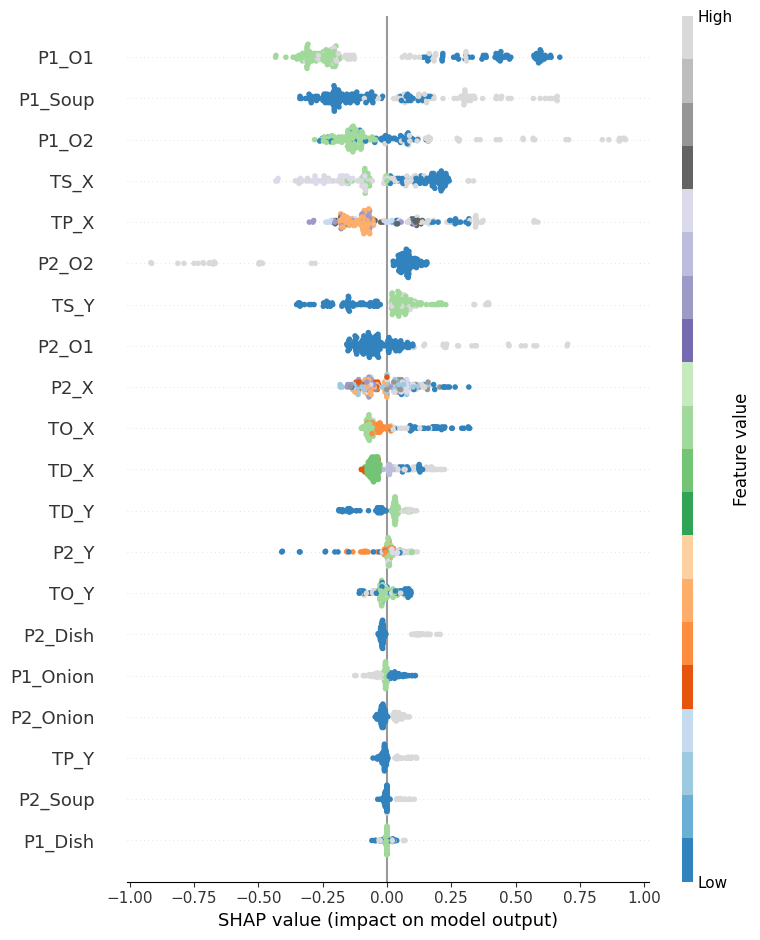

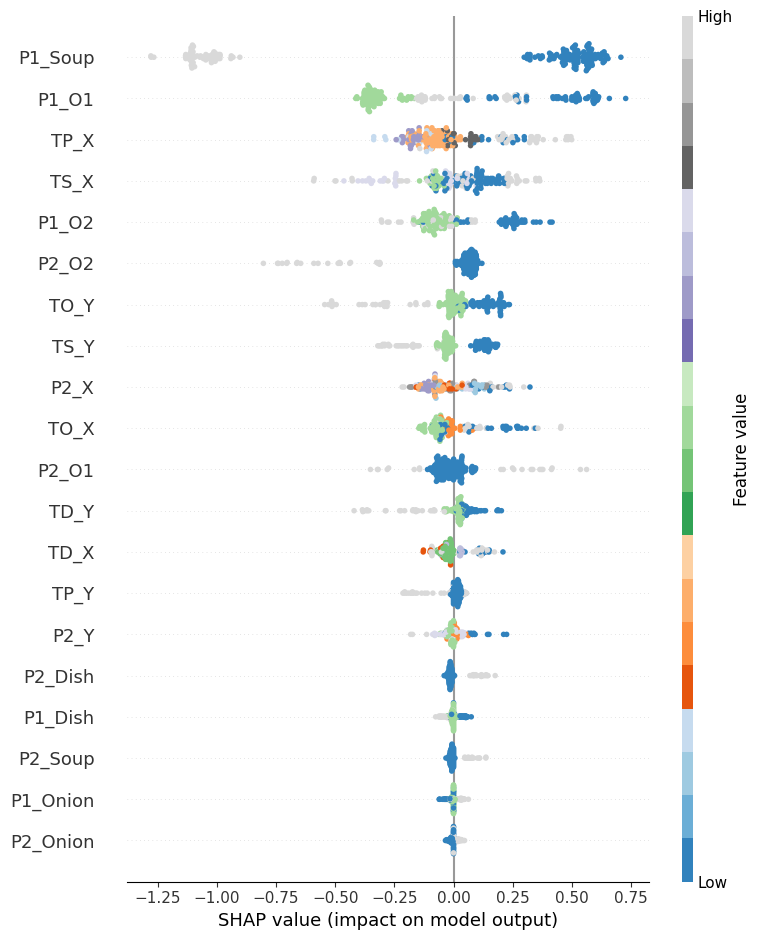

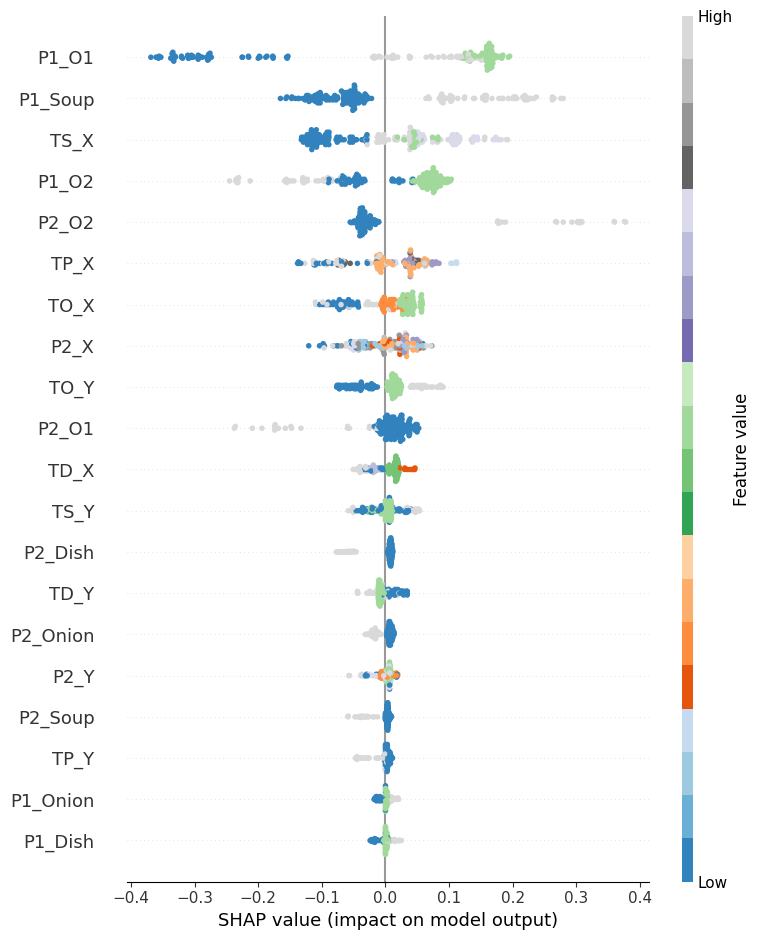

<Figure size 1000x400 with 0 Axes>

In [13]:
mlp_label = ["P2_X", "P2_Y", "P1_O1","P1_O2","P1_Onion","P1_Dish", "P1_Soup", "P2_O1","P2_O2","P2_Onion","P2_Dish", "P2_Soup","TP_X","TP_Y","TO_X","TO_Y","TD_X","TD_Y","TS_X","TS_Y"]
shapley(model_mlp.cpu(),test_loader,mlp_label,True)